# Segmenting GPS track

This section presents the problem of segmenting a GPS track based on discrete-value criteria or spatiotemporal criteria or a combination of both. The segmentation for a track consists to partition it into a number of pieces of *track*. The idea of segmentation is to obtain tracks where characteristics inside each ones are uniform in some sens.

In track library, segmentation takes place (cf. figure 1) in two stages. Once the indicators have been calculated, the first step is to create a new analytical feature, named "seg" for example, which value is: 0 if change of division, 1 otherwise by calling *segmentation* algorithm. The second step consists to split the track using "seg" analytical feature. A collection of tracks are created; all tracks are defined for all observations between the different values of 1 of "seg" AF from the original track.

<figure style='text-align:center;padding:1.5em'>
<img src="img/segmentation_process3.png"  width="650" />
<figcaption><br/>Figure 1 : process to segmenting track</figcaption>
</figure>


We have had a brief preview of this treatment in the quickstart use case. Indeed, in the GPS track corresponding to an athletics training, we segment the trajectory depending on the shifting the speed of his running. In this tutorial, we add a second analytical feature, the direction of the edge.

## Let's start by defining our environment

This task is only useful for the online notebook

In [1]:
import matplotlib.pyplot as plt

import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Loading GPS track data

Data represents a winding track from a itinerary (identifier N°903959).

-------------------------------------
GPS track #activity_5807084803 of user 0:
-------------------------------------
  Nb of pt(s):   190
  Ref sys id   : ENU
  Starting at  : 11/11/2020 15:39:54
  Ending at    : 11/11/2020 15:52:00
  Duration     : 726.000 s
  Length       : 2412.144 m
-------------------------------------



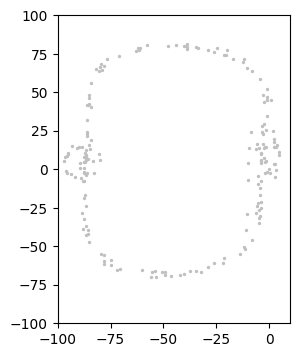

In [2]:
from tracklib.core.ObsTime import ObsTime
from tracklib.io.TrackReader import TrackReader

ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
tracks = TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)

# Transformation GEO coordinates to ENU
trace.toENUCoords()

trace.summary()

import numpy as np
trace.rotate(-np.pi/4)

plt.figure(figsize=(3, 4))
plt.scatter(trace.getX(), trace.getY(), marker='o', c='#C0C0C0', s=2)
plt.xlim([-100, 10])
plt.ylim([-100, 100])
plt.show()


## First basic method, with table index

Tout simplement, vous avez la liste des index des observations qui représentent les limites des différents fragments de la trace.

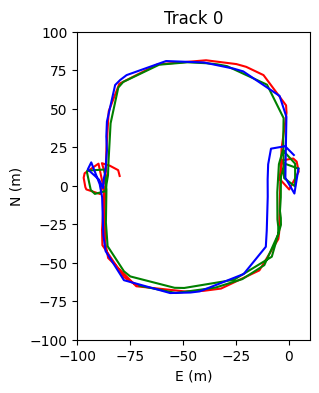

In [3]:
from tracklib.algo.Segmentation import split

idxFragments = [50, 100, 150, 189]
collection = split(trace, idxFragments)

plt.figure(figsize=(3, 4))
COLORS = ['r-','g-','b-','y-','m-','c-']
for i in range(len(collection)):
    collection[i].plot(COLORS[i%6], append=True)
plt.xlim([-100, 10])
plt.ylim([-100, 100])
plt.show()

## Segmenting under any of these AF or any combination of these AF


### Step 1: create criteria as Analytical Feature

Vous n'avez pas les bornes pour la segmenter mais vous avez une méthode pour les calculer. Autrement dit, vous avez un critère permettant 
de découper la trace. Comme par exemple, la trace du quickstart qui a été découpée suivant les changements de vitesses. 

Pour cela, il faut tout d'abord créer des points de rupture, ils seront définis par un AF qui aura un ensemble fini de valeurs. 
Une coupure sera effective à chaque seuil passé en paramètre.

Vous pouvez même combiner plusieurs AF pour découper la trace. Par défaut l'opérateur de comparaison est AND mais on peut le changer en OU.
Dans ce cas, l'ensemble des AF sont définis dans un tableau ainsi que leurs seuils.

A l'issu de la création des marqueurs, la trace est toujours conservée, mais une nouvelle AF est ajoutée. 
Elle a comme valeurs 0 sauf pour les ruptures, ce sera 1.








In [4]:
import tracklib.algo.Analytics as Analytics
from tracklib.core.Operator import Operator

trace.addAnalyticalFeature(Analytics.speed)
trace.operate(Operator.DIFFERENTIATOR, "speed", "dv")
trace.operate(Operator.RECTIFIER, "dv", "absdv")

trace.addAnalyticalFeature(Analytics.heading)
trace.operate(Operator.RECTIFIER, "heading", "absheading")
print ('')

In [5]:
from tracklib.algo.Segmentation import segmentation, split
from tracklib.algo.Segmentation import MODE_COMPARAISON_AND

segmentation(trace, ["absdv"], "decoup1", [1.5], MODE_COMPARAISON_AND)
segmentation(trace, ["absheading"], "decoup2", [0.1], MODE_COMPARAISON_AND)
segmentation(trace, ["absdv", "absheading"], "decoup3", [1.5, 0.1], MODE_COMPARAISON_AND)

### Step 2: split under any of these AF or any combination of these AF

Il reste à découper la trace suivant le marker créé précédemment. Pour cela, il faut appeler la même fonction **split** mais en spécifiant cette fois-ci
non pas une liste des index, mais le ou les AF


Splits track according to af name (considered as a marker) 


Return: No track if no segmentation, otherwise a TrackCollection object

In [6]:
TRACES1 = split(trace, "decoup1", limit=40)
TRACES2 = split(trace, "decoup2", limit=40)
TRACES3 = split(trace, "decoup3", limit=40)

(-100.0, 100.0)

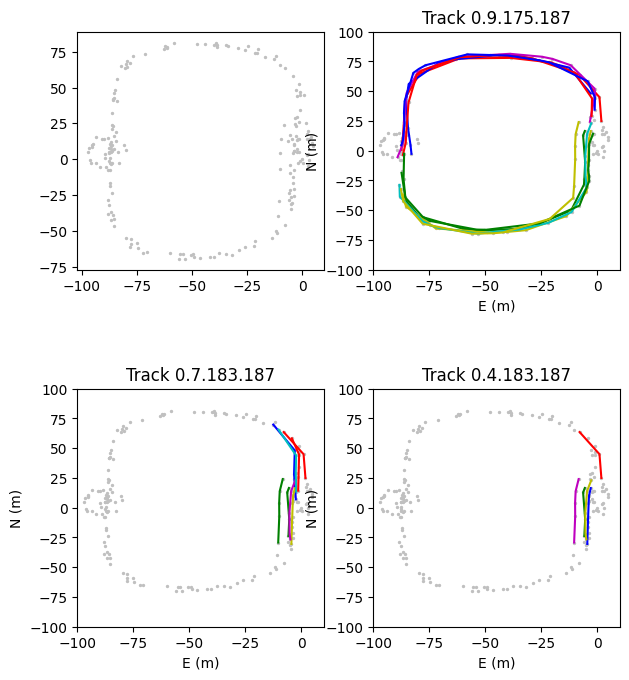

In [7]:
COLORS = ['r-','g-','b-','y-','m-','c-']

plt.figure(figsize=(7, 5))
plt.subplots_adjust(top=1.3, wspace=0.2, hspace=0.5)

# Figure 1
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.scatter(trace.getX(), trace.getY(), marker='o', c='#C0C0C0', s=2)

# Figure 2
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.scatter(trace.getX(), trace.getY(), marker='o', c='#C0C0C0', s=2)
for i in range(len(TRACES1)):
    track = TRACES1[i]
    track.plot(type='LINE', sym=COLORS[i%6], append=ax2)
ax2.set_xlim([-100, 10])
ax2.set_ylim([-100, 100])

# Figure 3
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.scatter(trace.getX(), trace.getY(), marker='o', c='#C0C0C0', s=2)
for i in range(len(TRACES2)):
    track = TRACES2[i]
    track.plot(type='LINE', sym=COLORS[i%6], append=ax3)
ax3.set_xlim([-100, 10])
ax3.set_ylim([-100, 100])

# Figure 4
ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.scatter(trace.getX(), trace.getY(), marker='o', c='#C0C0C0', s=2)
for i in range(len(TRACES3)):
    track = TRACES3[i]
    track.plot(type='LINE', sym=COLORS[i%6], append=ax4)
ax4.set_xlim([-100, 10])
ax4.set_ylim([-100, 100])